In [37]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import rqa_functions as rqa
from misc_utils import transform_tuples_to_symbols

from hdf5storage import loadmat, savemat

In [4]:
outdict = loadmat('cluster_embeddings.mat')
cluster_sequence=outdict['cluster_sequence']
low_dim_embeddings=outdict['low_dim_embeddings']

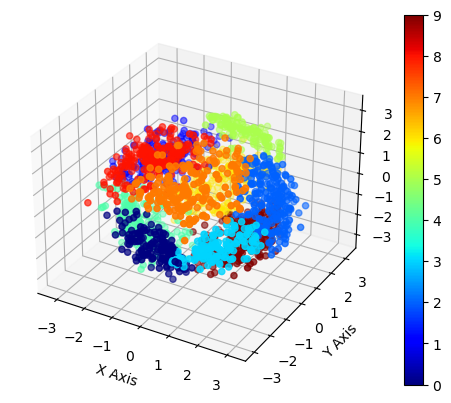

In [12]:
from mpl_toolkits.mplot3d import Axes3D
x=low_dim_embeddings[:,0]
y=low_dim_embeddings[:,1]
z=low_dim_embeddings[:,2]
# Create a figure and a 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Scatter plot
scatter=ax.scatter(x, y, z, c=cluster_sequence, cmap='jet')
# Add a color bar which maps the color values to the data
colorbar = plt.colorbar(scatter)
# Labels for axes
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

# Show plot
plt.show()

In [39]:
errors=loadmat('errors')
errors['20220713']['tr11']

array([ 226.,  358.,  360.,  237.,  347.,  314.,  289.,  362.,  457.,
        306.,  443.,  731.,  406.,  314.,  486.,  563.,  503.,  717.,
        741.,  103.,   57.,   58.,  261.,  463.,  559.,   25.,  728.,
         43.,  101.,  473.,  972.,  397.,  154.,   73.,  172.,  261.,
        173.,  162.,  131.,  221.,  244.,  267.,  336.,  447.,  337.,
        346.,  344.,  293.,  368.,  363.,  447.,  376.,  461.,  105.,
        266.,  247.,   61.,  366.,  258.,   15.,  319.,  339.,  329.,
        227.,  259.,  279.,   90.,  132.,  266.,  254.,  126.,  117.,
        115.,  161., 1421.,  227.,  112.,   99.,  258.,  181.,  102.,
        206.,  181.,  187.,  303.,  600.,  416.,  141.,   92.,  302.,
        182.,  174.,  166.,   55.,   74.,   22.,  168.,  772.,  207.,
         14.,   31.,   13.,   37.,   50.,  224.,  236.,  366.,  270.,
        135.,  285.,  249.,  291.,  286.,  247.,  290.,  593.,   63.,
         54.,   96.,   17.,   68.,   39.,  151.,  125.,  293.,  223.,
        301.,  291.,

In [14]:
outdict.keys()

dict_keys(['20220713', '20220721', '20220804', '20220808', '20220810', '20220811', '20220815', '20220816', '20221003', '2022100401', '2022100402', '20221005', 'errors'])

In [22]:
def load_pickle_file(filename):
    """
    Load a pickle file.

    Parameters:
    - filename (str): The path to the pickle file to be loaded.

    Returns:
    - The Python object loaded from the pickle file.
    """
    try:
        with open(filename, 'rb') as file:
            data = pickle.load(file)
            return data
    except FileNotFoundError:
        print(f"Error: The file '{filename}' was not found.")
    except EOFError:
        print(f"Error: The file '{filename}' may be corrupted or empty.")
    except pickle.UnpicklingError:
        print(f"Error: The file '{filename}' could not be unpickled. It may not be a valid pickle file or may be corrupted.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        
session_clusterings = load_pickle_file('./clustering_data.pkl')

In [29]:
list(session_clusterings.keys())

['20220721',
 '20220713',
 '20220816',
 '20220810',
 '20220804',
 '20221005',
 '2022100401',
 '20220815',
 '20221003',
 '2022100402',
 '20220808',
 '20220811']

In [24]:
import pickle
import numpy as np
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt
import os
import rqa_functions as rqa
from sklearn.manifold import MDS
from collections import defaultdict
from sklearn.mixture import GaussianMixture
import itertools
from misc_utils import save_to_pickle

/home/zhibinz2/anaconda3/envs/eeg/lib/python3.9/site-packages/sklearn/utils/multiclass.py:13: DeprecationWarning: Please use `spmatrix` from the `scipy.sparse` namespace, the `scipy.sparse.base` namespace is deprecated.
  from scipy.sparse.base import spmatrix
/home/zhibinz2/anaconda3/envs/eeg/lib/python3.9/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/home/zhibinz2/anaconda3/envs/eeg/lib/python3.9/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, 

In [25]:
def find_indices_to_eliminate(subj1, subj2):
    """
    Calculate the indices to be eliminated based on the differences in trial data points
    for two subjects, ensuring that only the necessary data points are removed to align their sizes.

    Parameters:
    - list_indices_subj1: Numpy array of trial sizes for subject 1
    - list_indices_subj2: Numpy array of trial sizes for subject 2

    Returns:
    - index_to_eliminate_subj1: Indices to eliminate from subject 1 to align with subject 2
    - index_to_eliminate_subj2: Indices to eliminate from subject 2 to align with subject 1
    """

    list_indices_subj1 = np.array([i[1] for i in subj1])
    list_indices_subj2 = np.array([i[1] for i in subj2])

    cumsum_subj1 = [sum([x[1] for x in subj1[:i+1]]) for i in range(len(subj1))]
    cumsum_subj2 = [sum([x[1] for x in subj2[:i+1]]) for i in range(len(subj2))]

    index_differences_sub1 = list_indices_subj1 - list_indices_subj2
    index_differences_sub2 = list_indices_subj2 - list_indices_subj1

    index_to_eliminate_subj1 = []
    for i,n_points in enumerate(index_differences_sub1):
        if n_points>0:
            indexes = [j for j in range(cumsum_subj1[i]-index_differences_sub1[i],cumsum_subj1[i])]
            index_to_eliminate_subj1.extend(indexes)

    index_to_eliminate_subj2 = []
    for i,n_points in enumerate(index_differences_sub2):
        if n_points>0:
            indexes = [j for j in range(cumsum_subj2[i]-index_differences_sub2[i],cumsum_subj2[i])]
            index_to_eliminate_subj2.extend(indexes)

    return index_to_eliminate_subj1[::-1], index_to_eliminate_subj2[::-1]


def session_data_loading(file_path):
    session = (file_path.split('/')[-1]).split('_')[1]
    with open(file_path, 'rb') as file:
        # Load the object from the pickle file
        data = pickle.load(file)

    subj1 = data['subj1']['sizes']
    subj2 = data['subj2']['sizes']

    index_to_eliminate_subj1, index_to_eliminate_subj2 = find_indices_to_eliminate(subj1, subj2)

    file_order_size = []
    for i in range(len(subj1)):
        file_sub1,len_1 = subj1[i]
        file_sub2,len_2 = subj2[i]
        if len_1 < len_2:
            file_order_size.append((file_sub1,file_sub2,len_1))
        else:
            file_order_size.append((file_sub1,file_sub2,len_2))

    mat1 = data['subj1']['distances']
    for index in index_to_eliminate_subj1:
        mat1 = np.delete(np.delete(mat1, index, axis=0), index, axis=1)

    mat2 = data['subj2']['distances']
    for index in index_to_eliminate_subj2:
        mat2 = np.delete(np.delete(mat2, index, axis=0), index, axis=1)

    trial_len = [i[2] for i in file_order_size]
    start_points = list(np.cumsum(trial_len))
    end_points = [i-1 for i in start_points]
    start_points.insert(0,0)
    start_points.pop(-1)
    #print(start_points)
    #print(end_points)
    start_stop = list(zip(start_points,end_points))
    #print(start_stop)

    condition_dictionary = {1: 'Uncoupled', 2: '1_lead', 3: '2_lead', 4: 'Mutual'}
    type_dictionary = {1: 'Synchronization', 2: 'Syncopation'}

    # Initialize an empty list to store each row's data as a dictionary
    data = []

    for i, entry in enumerate(file_order_size):
        session = entry[0].split('/')[0]
        trial = entry[0].split('_')[2][:-4]
        length = entry[2]
        start, stop = start_stop[i]
        # filename = '/data/Italo/finger_tapping_behavioral_data/clean_' + str(session) + '_bpchan.mat'
        # filename = 'C:/Users\zhouz\GitHub/finger_tapping_behavioral_data/clean_' + str(session) + '_bpchan.mat'
        filename = '/home/zhibinz2/Documents/GitHub/finger_tapping_behavioral_data/clean_' + str(session) + '_bpchan.mat'
        beh_data = loadmat(filename)
        conditions = list(beh_data['conditions'][0])
        condition = condition_dictionary[conditions[int(trial)-1]]
        session_type = type_dictionary[beh_data['session'][0][0]]
        # add samples 
        samples = beh_data['samples'][0]

        # Instead of printing, store the data in a dictionary
        row_data = {
            'session': session,
            'session_type': session_type,
            'condition': condition,
            'trial': trial,
            'start': start,
            'stop': stop,
        }

        # Append the dictionary to the list
        data.append(row_data)

    # Convert the list of dictionaries to a pandas DataFrame
    metadata = pd.DataFrame(data)
    session_data = {'Subject 1': mat1,
                    'Subject 2': mat2,
                    'Metadata': metadata,
                    'Session Type': session_type,
                    'samples': samples}
    return session, session_data

In [27]:
directory_path = "/ssd/zhibin/1overf/Cleaned_sourcedata/cortical_source_data/taplocked/correlation_distances/"
# List all files and directories in the specified path
all_items = os.listdir(directory_path)
# Filter out files that start with "dyad_20"
matching_files = [filename for filename in all_items if filename.startswith("dyad_20")]
# Optionally, get the full paths if needed
full_paths = [os.path.join(directory_path, filename) for filename in matching_files]
# Print the list of matching file paths
for file_path in full_paths:
    print(file_path)

/ssd/zhibin/1overf/Cleaned_sourcedata/cortical_source_data/taplocked/correlation_distances/dyad_20220721_distances.pkl
/ssd/zhibin/1overf/Cleaned_sourcedata/cortical_source_data/taplocked/correlation_distances/dyad_20220713_distances.pkl
/ssd/zhibin/1overf/Cleaned_sourcedata/cortical_source_data/taplocked/correlation_distances/dyad_20220816_distances.pkl
/ssd/zhibin/1overf/Cleaned_sourcedata/cortical_source_data/taplocked/correlation_distances/dyad_20220810_distances.pkl
/ssd/zhibin/1overf/Cleaned_sourcedata/cortical_source_data/taplocked/correlation_distances/dyad_20220804_distances.pkl
/ssd/zhibin/1overf/Cleaned_sourcedata/cortical_source_data/taplocked/correlation_distances/dyad_20221005_distances.pkl
/ssd/zhibin/1overf/Cleaned_sourcedata/cortical_source_data/taplocked/correlation_distances/dyad_2022100401_distances.pkl
/ssd/zhibin/1overf/Cleaned_sourcedata/cortical_source_data/taplocked/correlation_distances/dyad_20220815_distances.pkl
/ssd/zhibin/1overf/Cleaned_sourcedata/cortical

In [28]:
# Loads the correlation matrices in a single dictionary.
session_data = {}
for file_path in full_paths:
    session,data = session_data_loading(file_path)
    session_data[session] = data

In [33]:
session_data['20220721'].keys()

dict_keys(['Subject 1', 'Subject 2', 'Metadata', 'Session Type', 'samples'])

In [34]:
for session_code in session_data:
    print(session_code)

20220721
20220713
20220816
20220810
20220804
20221005
2022100401
20220815
20221003
2022100402
20220808
20220811


In [43]:
session_errors['tr'+str(j+1)]

array([523., 555., 278., 545., 719., 442., 383., 550., 375., 632., 157.,
       551., 414., 592., 512., 405., 228., 246., 463., 436., 542., 456.,
       494., 591., 400., 495., 488., 171., 125., 467., 587., 431.,  93.,
       510., 326.,  29., 592., 571., 518., 365., 434., 592., 500., 522.,
       304., 555., 554., 425., 182., 615., 500., 503., 329., 177., 519.,
       618., 542., 491., 483., 509., 407., 256., 310., 472., 359., 527.,
       549., 387., 349., 470., 600., 501., 554., 423., 232., 298., 490.,
       630., 554., 512.,  44., 581., 303., 461., 506., 407., 226., 290.,
       610., 466., 225., 500., 658., 528., 549.,  41., 616., 334.,  61.,
       500., 655., 679., 506., 328.,  69., 545., 489., 329., 419., 636.,
       535., 408., 286., 637., 525., 592., 553., 540., 194., 599., 436.,
       400., 556., 559., 537., 492., 535., 330.,  73.,  70., 158., 328.,
       458., 499., 521., 331.,  77., 453., 433., 536., 625., 655., 620.,
       621., 490., 609., 730., 643., 657., 633., 61

In [93]:
data = []
recurrence_plots = {}

for session_code in session_data:
    metadata = session_data[session_code]['Metadata']
    sub1_seq,sub2_seq = session_clusterings[session_code]
    joint_seq = list(zip(sub1_seq,sub2_seq))
    joint_seq = transform_tuples_to_symbols(joint_seq)

    start_list = list(metadata['start'])
    stop_list = list(metadata['stop'])
    start_stop = list(zip(start_list,stop_list))
    conditions = list(metadata['condition'])
    session_type = metadata['session_type'][0]

    recurrence_matrix = rqa.build_rp(joint_seq)
    recurrence_plots[session_code] = {'rp': recurrence_matrix,
                                      'symbol_sequence': joint_seq}

    session_errors=errors[session_code]

    for j,indices in enumerate(start_stop):
        condition = conditions[j]
        if condition == '1_lead' or condition == '2_lead':
            condition = 'Leader-Follower'
        start, stop = indices
        
        matrix = recurrence_matrix[start:stop,start:stop]

        vlines = rqa.find_lines(matrix, min_len=2, direction='vertical')
        vmean = np.mean(vlines)
        vvar = np.var(vlines)
        dlines = rqa.find_lines(matrix, min_len=2, direction='diagonal')
        dmean = np.mean(dlines)
        dvar = np.var(dlines)

        tr_errors=session_errors['tr'+str(j+1)]
        emean=np.mean(tr_errors)
        evar=np.var(tr_errors)


        df_row = {'Session': session_code,
                'Session Type': session_type,
                'Condition': condition,
                'Average Dwell Time': vmean,
                'Average Motif Length': dmean,
                'Average Error': emean,
                'Var Dwell Time': vvar,
                'Var Motif Length': dvar,
                'Var Error': evar}
        data.append(df_row)

data_df = pd.DataFrame(data)
data_df

Session Session Type        Condition  Average Dwell Time  \
0    20220721  Syncopation  Leader-Follower            2.033333   
1    20220721  Syncopation  Leader-Follower            2.137778   
2    20220721  Syncopation           Mutual            2.000000   
3    20220721  Syncopation        Uncoupled            2.000000   
4    20220721  Syncopation  Leader-Follower            2.000000   
..        ...          ...              ...                 ...   
139  20220811  Syncopation           Mutual            2.089958   
140  20220811  Syncopation        Uncoupled            2.332046   
141  20220811  Syncopation           Mutual            2.107612   
142  20220811  Syncopation  Leader-Follower            2.238477   
143  20220811  Syncopation  Leader-Follower            2.203980   

     Average Motif Length  Average Error  Var Dwell Time  Var Motif Length  \
0                2.083333     448.074074        0.032222          0.076389   
1                2.103896     544.057143        0.118795          0.093102   
2                2.040000     613.936170        0.000000          0.038400   
3                2.000000     333.985401        0.000000          0.000000   
4                2.000000     515.339394        0.000000          0.000000   
..                    ...            ...             ...               ...   
139              2.118012     575.038889        0.081866          0.116508   
140              2.119403     318.923077        0.221792          0.105146   
141              2.991870     584.282609        0.096031         29.487739   
142              2.181250     567.948571        0.181606          0.248398   
143              2.145161     493.681250        0.162372          0.156348   

        Var Error  
0    26241.550069  
1    28826.408163  
2    13704.045571  
3    36807.357451  
4    37219.569660  
..            ...  
139   7592.837377  
140  31736.644432  
141   7224.738973  
142  10086.528784  
143   8513.404648  

[144 rows x 9 columns]

54
48
48
64
88
62
62
90
81
42
67
60


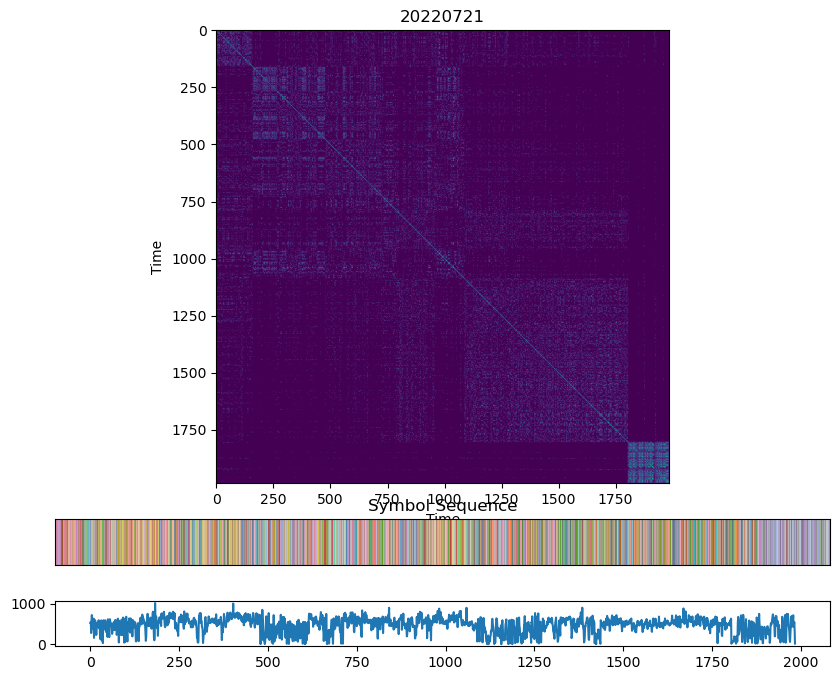

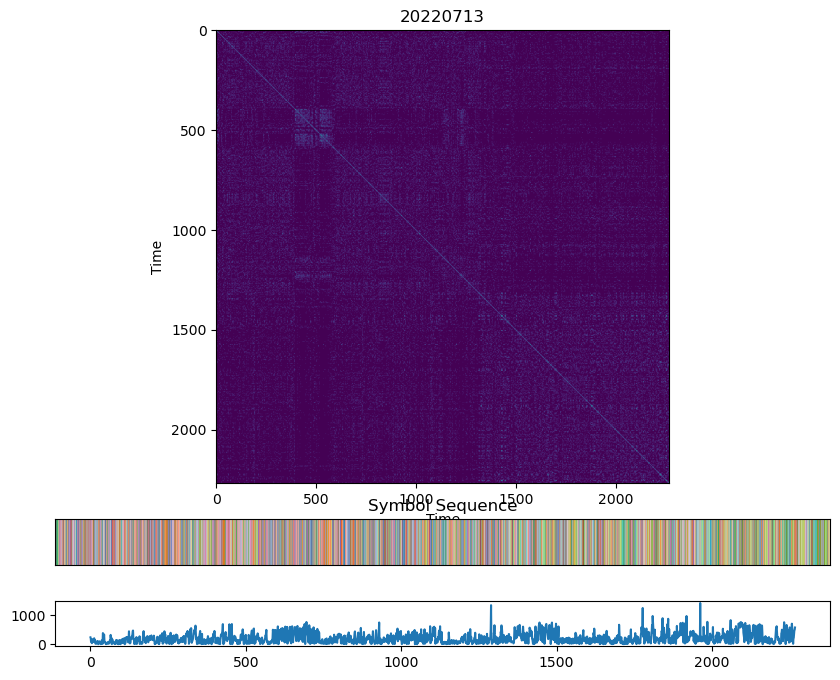

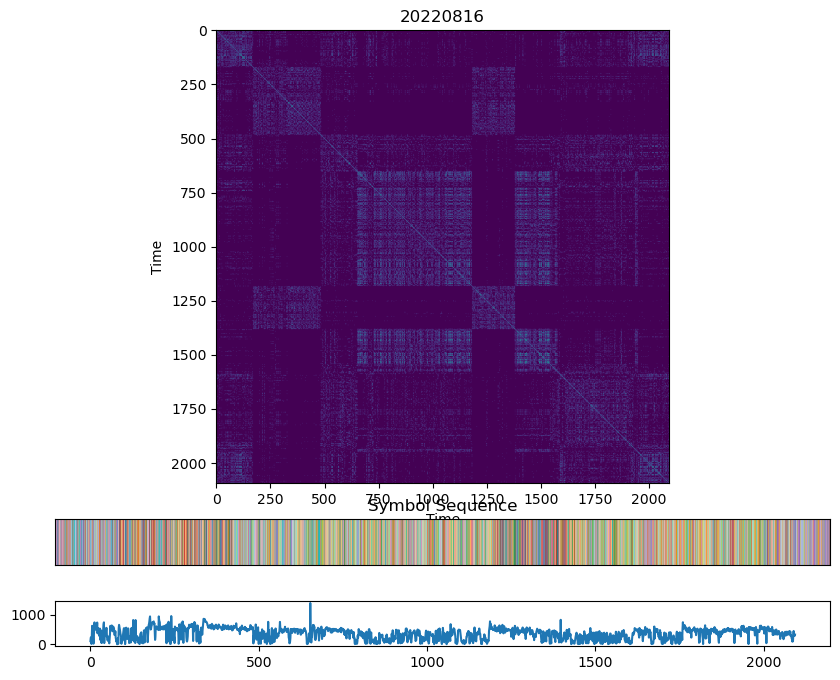

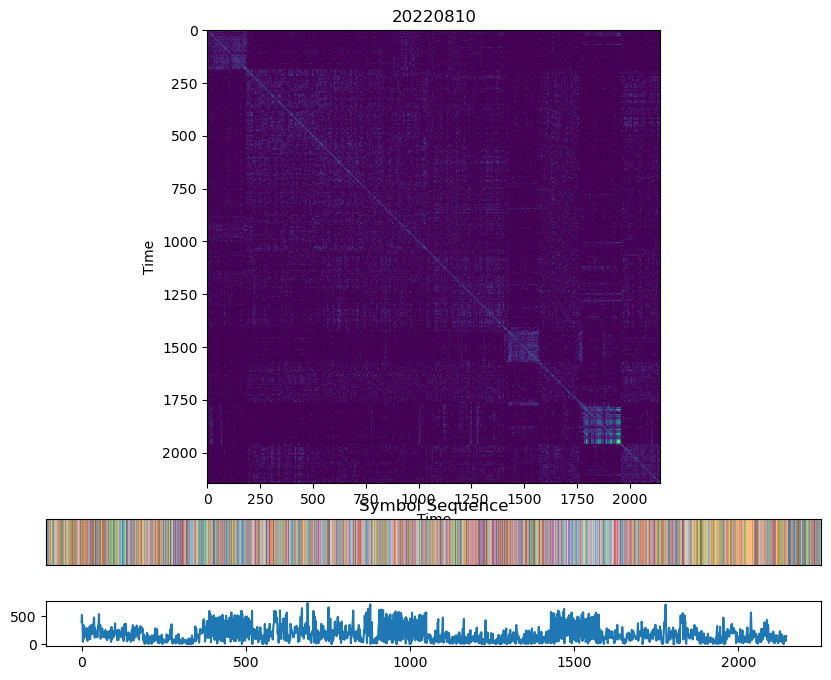

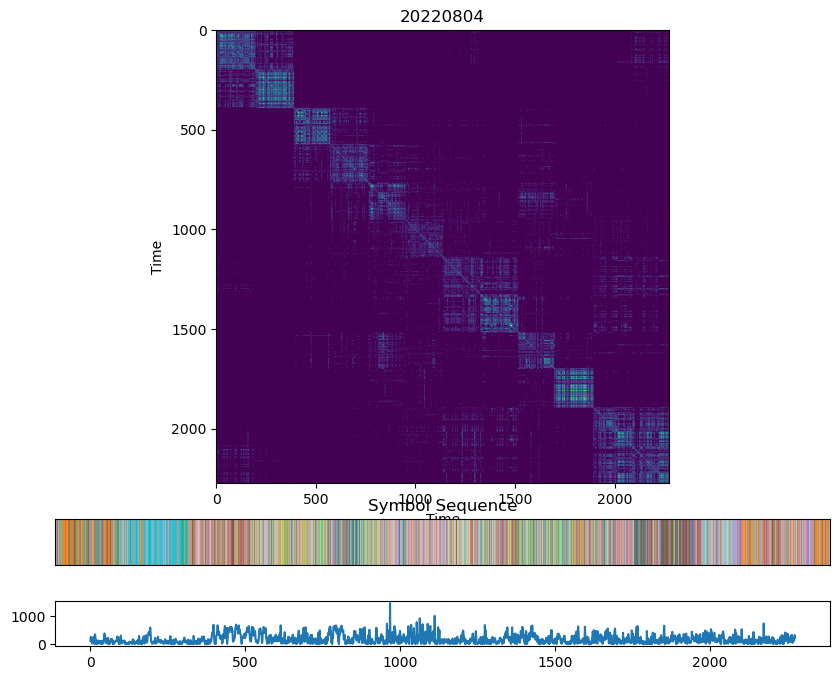

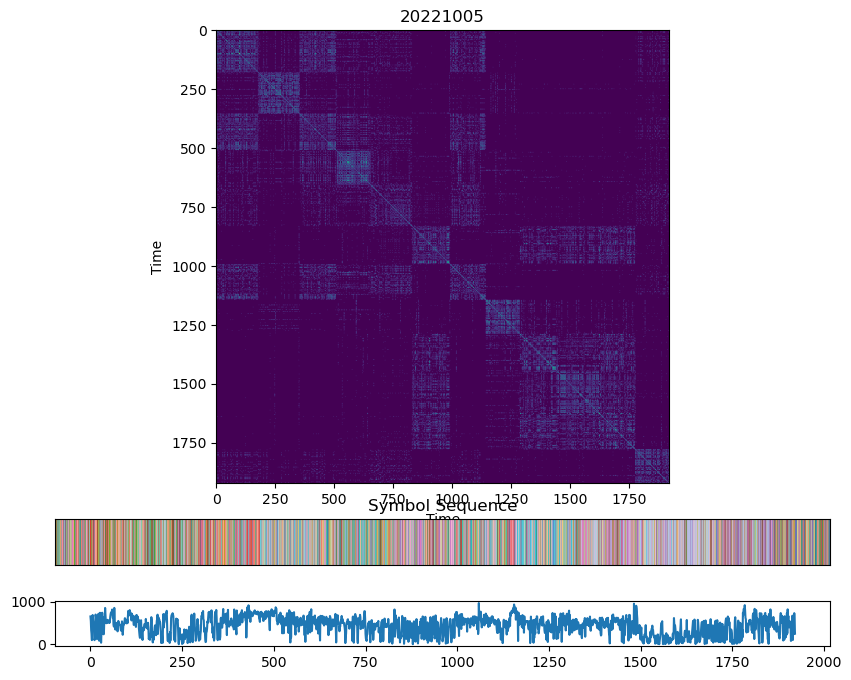

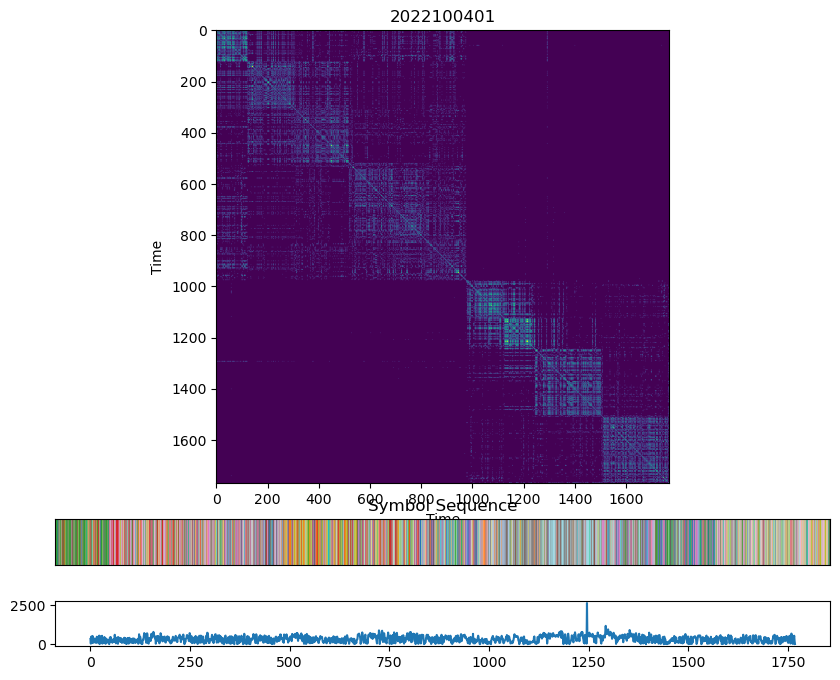

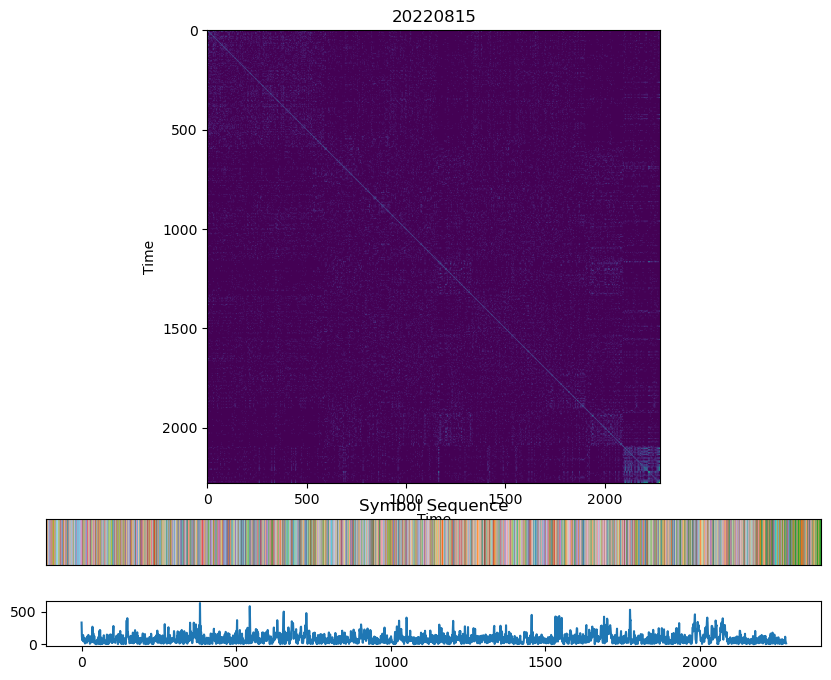

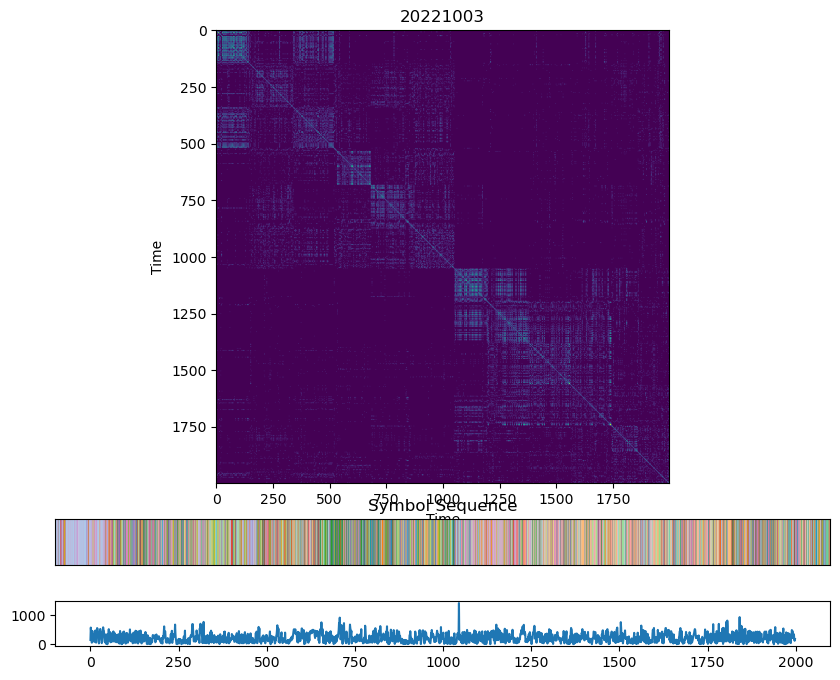

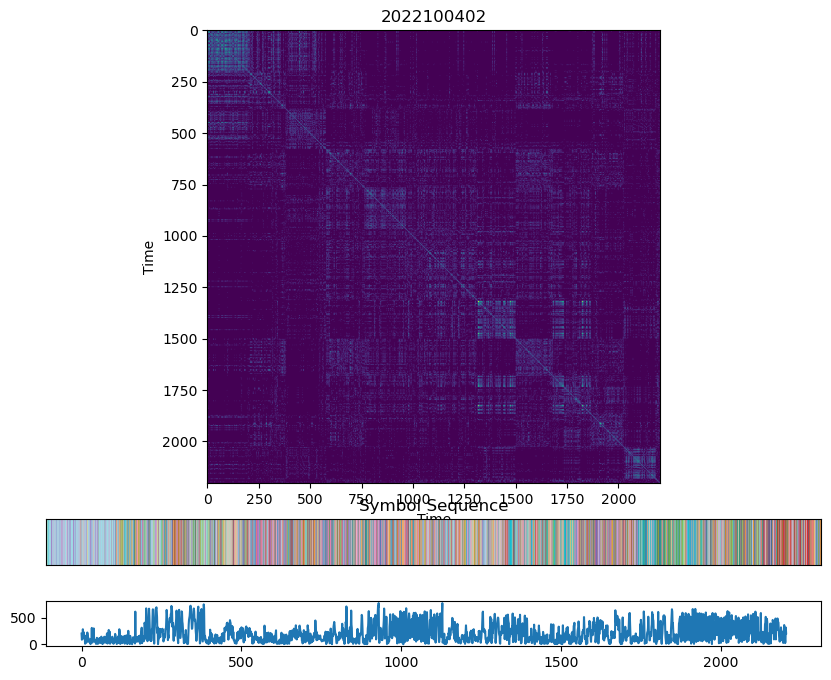

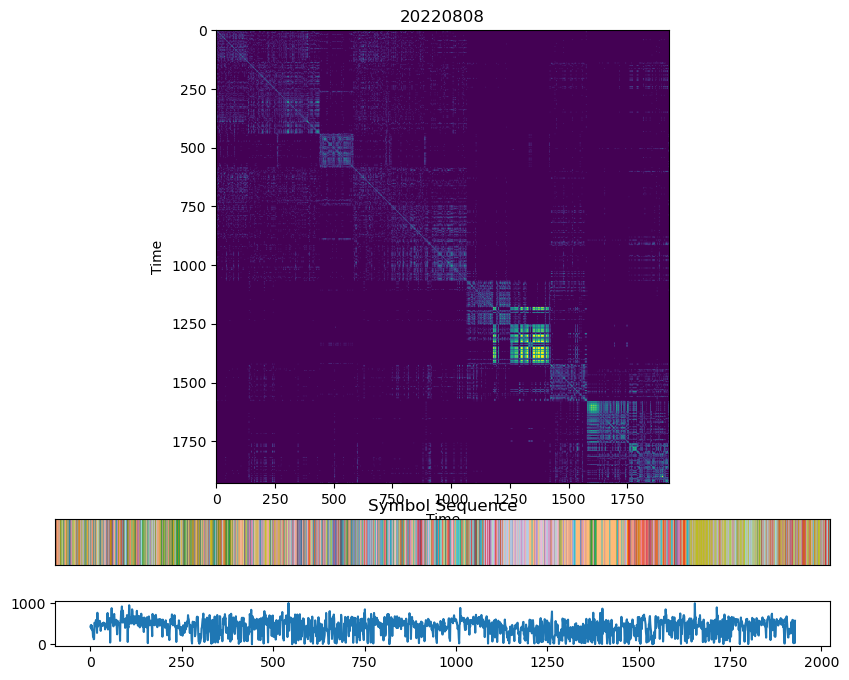

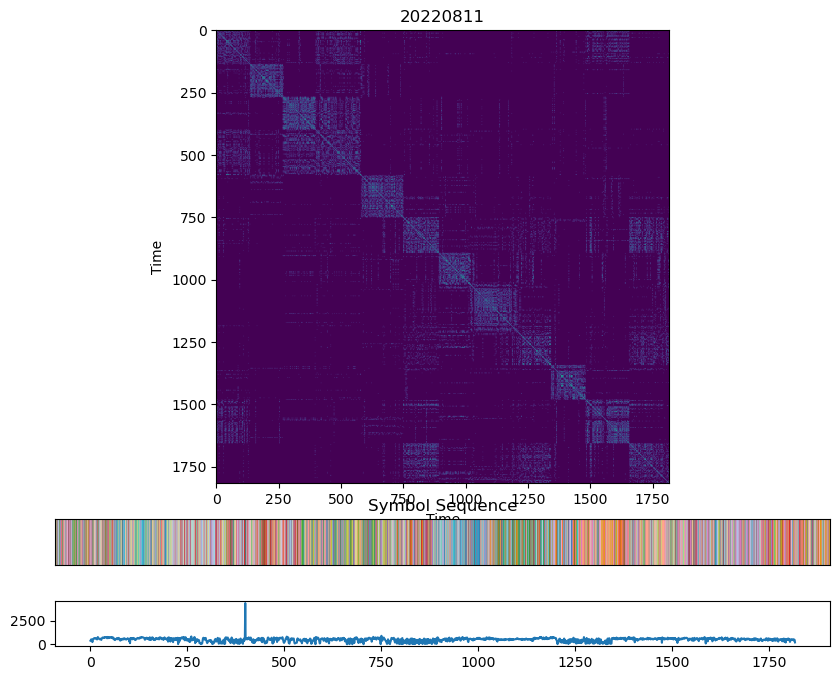

In [90]:
for session_code in recurrence_plots:
    recurrence_matrix = recurrence_plots[session_code]['rp']
    joint_seq = recurrence_plots[session_code]['symbol_sequence']
    session_errors = errors[session_code]
    
    tr12_errors=session_errors['tr'+str(0+1)]
    for j in range(1,12):
        tr12_errors=np.concatenate((tr12_errors,session_errors['tr'+str(j+1)]))

    # Step 1: Create a color map
    unique_symbols = np.unique(joint_seq)
    print(len(unique_symbols))
    # Create a colormap that maps each symbol to a color
    symbol_to_color = plt.cm.get_cmap('tab20', len(unique_symbols))
    symbol_colors = {symbol: symbol_to_color(i) for i, symbol in enumerate(unique_symbols)}

    # Initialize the figure with GridSpec
    fig = plt.figure(figsize=(10, 8))
    gs = gridspec.GridSpec(3, 1, height_ratios=[10, 1, 1])

    # Step 2: Plot the Recurrence Matrix in a subplot
    ax1 = fig.add_subplot(gs[0])
    ax1.imshow(recurrence_matrix)
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Time')
    ax1.set_title(session_code)
    ax1.axis('on')

    # Step 3: Generate the Symbol Colorbar in another subplot
    # Create an array where each position corresponds to the color of the symbol at that position in the sequence
    symbol_sequence_colors = np.array([symbol_colors[symbol] for symbol in joint_seq]).reshape(1, len(joint_seq), 4)
    ax2 = fig.add_subplot(gs[1])
    ax2.imshow(symbol_sequence_colors, aspect='auto')
    ax2.set_title("Symbol Sequence")
    ax2.set_yticks([])
    ax2.set_xticks([])

    # Step 4: plot the errors
    ax3 = fig.add_subplot(gs[2])
    plt.plot(np.arange(len(tr12_errors)),tr12_errors)

    # 12 plots below
    # 5 s

In [94]:
columns_to_normalize = ['Average Dwell Time', 'Average Motif Length','Average Error']

# Apply the custom transformation
for col in columns_to_normalize:
    data_df[col + ' Normalized'] = data_df.groupby(['Session'])[col].transform(lambda x: np.log2(x / x.mean()))

In [95]:
data_df

Session Session Type        Condition  Average Dwell Time  \
0    20220721  Syncopation  Leader-Follower            2.033333   
1    20220721  Syncopation  Leader-Follower            2.137778   
2    20220721  Syncopation           Mutual            2.000000   
3    20220721  Syncopation        Uncoupled            2.000000   
4    20220721  Syncopation  Leader-Follower            2.000000   
..        ...          ...              ...                 ...   
139  20220811  Syncopation           Mutual            2.089958   
140  20220811  Syncopation        Uncoupled            2.332046   
141  20220811  Syncopation           Mutual            2.107612   
142  20220811  Syncopation  Leader-Follower            2.238477   
143  20220811  Syncopation  Leader-Follower            2.203980   

     Average Motif Length  Average Error  Var Dwell Time  Var Motif Length  \
0                2.083333     448.074074        0.032222          0.076389   
1                2.103896     544.057143        0.118795          0.093102   
2                2.040000     613.936170        0.000000          0.038400   
3                2.000000     333.985401        0.000000          0.000000   
4                2.000000     515.339394        0.000000          0.000000   
..                    ...            ...             ...               ...   
139              2.118012     575.038889        0.081866          0.116508   
140              2.119403     318.923077        0.221792          0.105146   
141              2.991870     584.282609        0.096031         29.487739   
142              2.181250     567.948571        0.181606          0.248398   
143              2.145161     493.681250        0.162372          0.156348   

        Var Error  Average Dwell Time Normalized  \
0    26241.550069                      -0.038383   
1    28826.408163                       0.033883   
2    13704.045571                      -0.062229   
3    36807.357451                      -0.062229   
4    37219.569660                      -0.062229   
..            ...                            ...   
139   7592.837377                      -0.061117   
140  31736.644432                       0.097006   
141   7224.738973                      -0.048982   
142  10086.528784                       0.037927   
143   8513.404648                       0.015521   

     Average Motif Length Normalized  Average Error Normalized  
0                          -0.149884                 -0.097792  
1                          -0.135714                  0.182229  
2                          -0.180208                  0.356559  
3                          -0.208777                 -0.521744  
4                          -0.208777                  0.103994  
..                               ...                       ...  
139                        -0.112669                  0.215876  
140                        -0.111722                 -0.634575  
141                         0.385668                  0.238883  
142                        -0.070224                  0.197977  
143                        -0.094293                 -0.004204  

[144 rows x 12 columns]

In [96]:
aux_df = data_df[data_df['Session Type'] == 'Synchronization']

In [97]:
aux_df

Session     Session Type        Condition  Average Dwell Time  \
12     20220713  Synchronization  Leader-Follower            2.000000   
13     20220713  Synchronization  Leader-Follower            2.000000   
14     20220713  Synchronization           Mutual            2.295000   
15     20220713  Synchronization        Uncoupled            2.000000   
16     20220713  Synchronization  Leader-Follower            2.000000   
..          ...              ...              ...                 ...   
115  2022100402  Synchronization           Mutual            2.739645   
116  2022100402  Synchronization  Leader-Follower            2.000000   
117  2022100402  Synchronization  Leader-Follower            2.487759   
118  2022100402  Synchronization        Uncoupled            2.456522   
119  2022100402  Synchronization           Mutual            2.299335   

     Average Motif Length  Average Error  Var Dwell Time  Var Motif Length  \
12               2.000000     120.091371        0.000000          0.000000   
13               2.000000     179.000000        0.000000          0.000000   
14               4.112360     181.417989        0.407975        367.785128   
15               2.000000     314.784314        0.000000          0.000000   
16               2.000000     156.263959        0.000000          0.000000   
..                    ...            ...             ...               ...   
115              8.568966     178.792350        2.115647       1012.210761   
116              2.086957     208.763736        0.000000          0.079395   
117              3.512397     197.864583        0.690528         78.365549   
118              6.442308     298.154839        1.161153        467.208210   
119              2.078652     249.304598        0.209733          0.072466   

        Var Error  Average Dwell Time Normalized  \
12    9787.057641                      -0.087444   
13   16902.404040                      -0.087444   
14   21434.592481                       0.111050   
15   34006.169166                      -0.087444   
16   14178.904945                      -0.087444   
..            ...                            ...   
115  20546.241034                       0.298065   
116  18970.521103                      -0.155924   
117  27864.533746                       0.158923   
118  30889.395380                       0.140693   
119  25037.717565                       0.045293   

     Average Motif Length Normalized  Average Error Normalized  
12                         -0.481909                 -0.819431  
13                         -0.481909                 -0.243604  
14                          0.558057                 -0.224246  
15                         -0.481909                  0.570800  
16                         -0.481909                 -0.439579  
..                               ...                       ...  
115                         1.442153                 -0.239886  
116                        -0.595568                 -0.016299  
117                         0.155488                 -0.093657  
118                         1.030609                  0.497891  
119                        -0.601320                  0.239739  

[72 rows x 12 columns]

In [98]:
session_list = list(set(aux_df['Session']))

In [99]:
session_list

['20220810', '20220713', '20221003', '20220815', '2022100402', '20220804']

In [100]:
session_mapping = {}

In [101]:
for i,session in enumerate(session_list):
    session_mapping[session] = i+1
session_mapping

{'20220810': 1,
 '20220713': 2,
 '20221003': 3,
 '20220815': 4,
 '2022100402': 5,
 '20220804': 6}

/tmp/ipykernel_34613/313869536.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux_df['Session'] = aux_df['Session'].map(session_mapping)


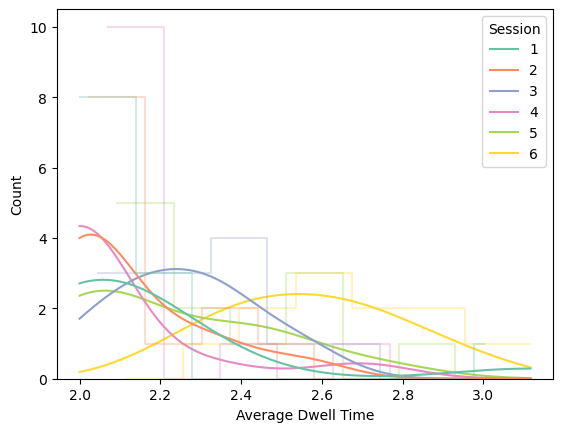

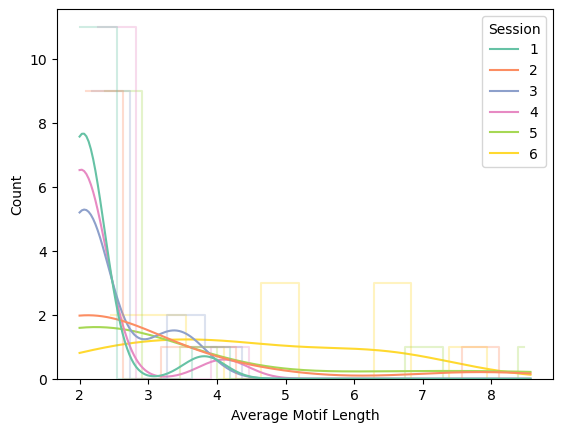

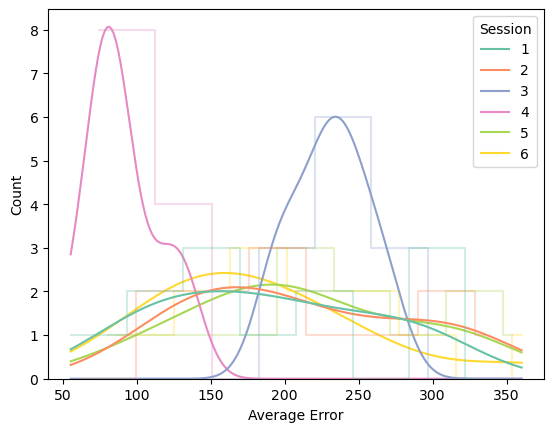

/tmp/ipykernel_34613/313869536.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux_df['Session'] = aux_df['Session'].map(session_mapping)


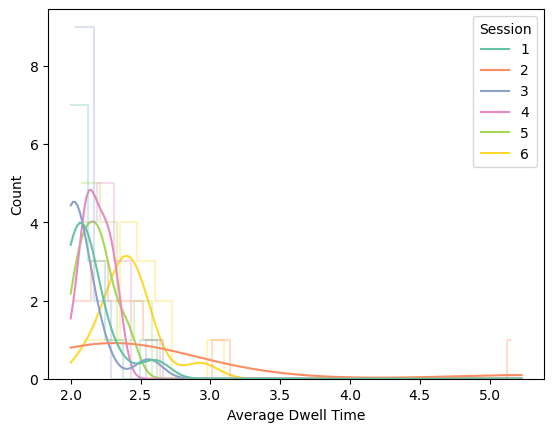

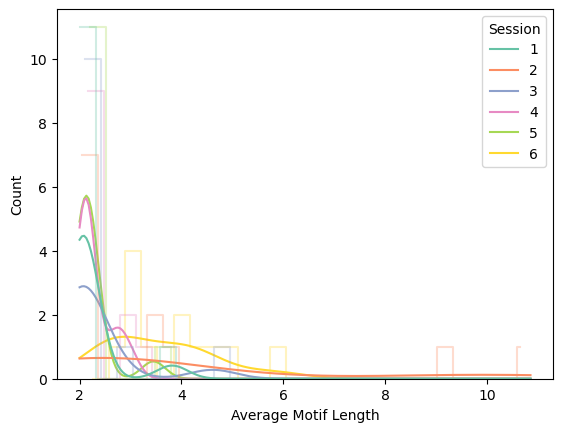

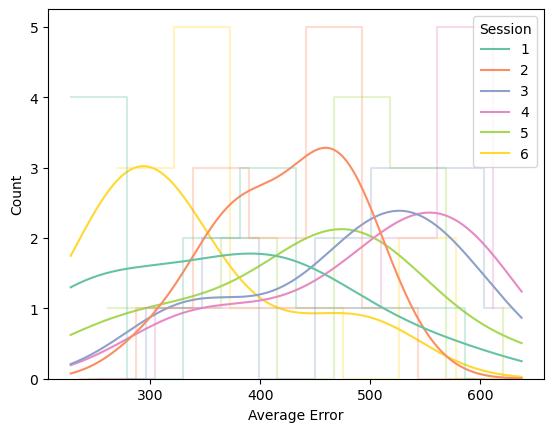

In [103]:
aux_df = data_df[data_df['Session Type'] == 'Synchronization']

session_list = list(set(aux_df['Session']))
session_mapping = {}
for i,session in enumerate(session_list):
    session_mapping[session] = i+1
session_mapping
aux_df['Session'] = aux_df['Session'].map(session_mapping)
metric_list = ['Average Dwell Time','Average Motif Length','Average Error']

for metric in metric_list:
    sns.histplot(aux_df, x=metric,hue='Session',multiple='dodge',kde=True,palette='Set2', element='step', fill=False, alpha=0.3)

    legend = plt.gca().get_legend()
    for handle in legend.legendHandles:
        handle.set_alpha(1)  # Set the legend markers to fully opaque
        
    plt.show()


aux_df = data_df[data_df['Session Type'] == 'Syncopation']

session_list = list(set(aux_df['Session']))
session_mapping = {}
for i,session in enumerate(session_list):
    session_mapping[session] = i+1
session_mapping
aux_df['Session'] = aux_df['Session'].map(session_mapping)
metric_list = ['Average Dwell Time','Average Motif Length','Average Error']

for metric in metric_list:
    sns.histplot(aux_df, x=metric,hue='Session',multiple='dodge',kde=True,palette='Set2', element='step', fill=False, alpha=0.3)

    legend = plt.gca().get_legend()
    for handle in legend.legendHandles:
        handle.set_alpha(1)  # Set the legend markers to fully opaque
        
    plt.show()

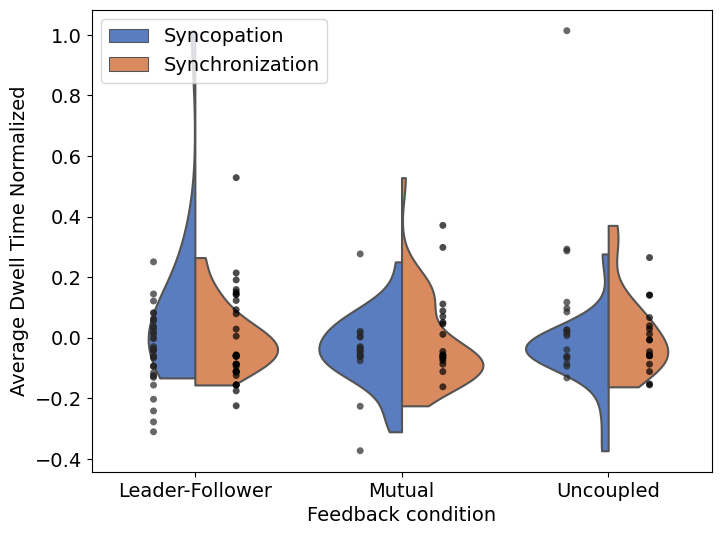

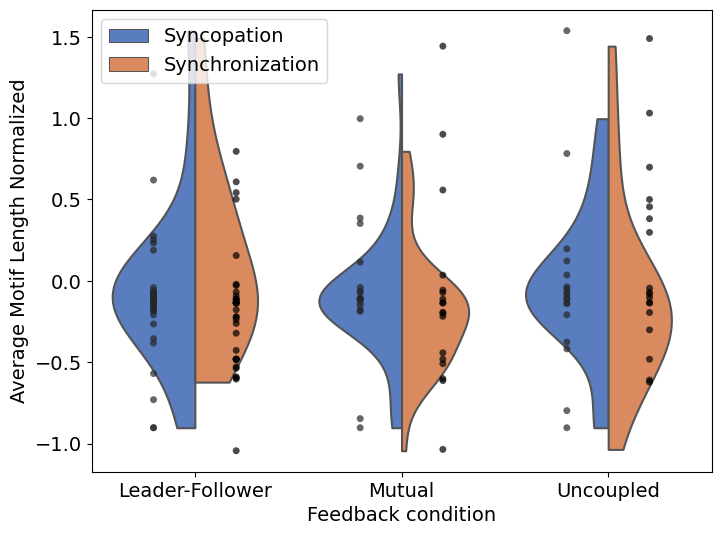

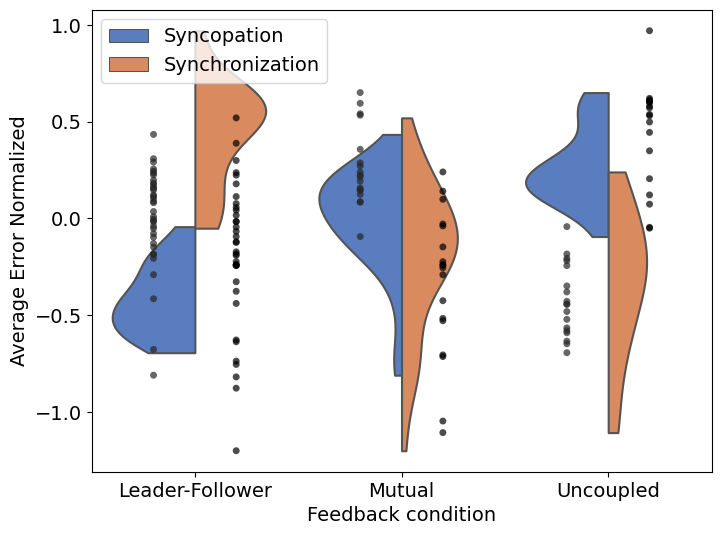

In [105]:
# Set global font size for all elements
plt.rcParams.update({'font.size': 14})

metric_list = ['Average Dwell Time Normalized','Average Motif Length Normalized','Average Error Normalized']

# # Define the tick values and labels
# log2_tick_values = np.log2([3, 2, 1.5, 4/3, 1, 3/4, 2/3, 1/2, 1/3])
# tick_labels = ['3', '2', '1.5', '4/3', '1', '3/4', '2/3', '1/2', '1/3']

# log2_tick_values2 = np.log2([1.5, 4/3, 1, 3/4, 2/3])
# tick_labels2 = ['1.5', '4/3', '1', '3/4', '2/3']

for metric in metric_list:
    fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
    condition_order = ['Uncoupled', 'Leader-Follower', 'Mutual']

    # Create the violin plot
    sns.violinplot(x='Condition', y=metric, hue='Session Type', data=data_df, split=True, inner=None, order=condition_order, palette='muted', cut=0, ax=ax)
    sns.stripplot(x='Condition', y=metric, hue='Session Type', data=data_df, dodge=True, color='black', edgecolor='black', size=5, alpha=0.7, jitter=False, ax=ax)

    # Add titles and labels as needed
    ax.set_xlabel('Feedback condition')
    ax.set_ylabel(metric)

    # # Set y-axis tick locations and labels
    # if metric == 'Average Dwell Time Normalized':
    #     ax.set_yticks(log2_tick_values2)
    #     ax.set_yticklabels(tick_labels2)
    # elif metric == 'Average Motif Length Normalized':
    #     ax.set_yticks(log2_tick_values)
    #     ax.set_yticklabels(tick_labels)
    # else:
    #     ax.set_yticks(log2_tick_values)
    #     ax.set_yticklabels(tick_labels)



    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[0:2], labels[0:2], loc='upper left')

    # Display the plot
    plt.show()
